In [3]:
import numpy as np
import string 
import scipy.io
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
import itertools
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
import numpy as np
import string 
import scipy.io
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
import itertools
from sklearn import svm
import statsmodels.api as sm # import statsmodels 
from scipy import signal
from sklearn.decomposition import *
from sklearn.linear_model import *
import sklearn
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score

class Scan(object):
    def __init__(self,activations,timestamp, step,prev_words=None,next_words=None,all_words=None,all_pos=None,all_speak_features=None,current_translated_words=None):
        self.activations = activations
        self.timestamp = timestamp
        self.prev_words = prev_words
        self.next_words = next_words
        self.step = step
        self.all_words = all_words
        self.current_translated_words = current_translated_words
        self.all_pos = all_pos
        self.all_speak_features = all_speak_features
        self.brain3d = None
        
        
        

def eval(dists,e_dists):
    nn_index = np.argmin(dists,axis=1)
    accuracy_on_test = np.mean(nn_index == np.argmax(np.eye(dists.shape[0]),axis=1))


    b_acc = []
    e_b_acc = []
    for i,j in itertools.combinations(np.arange(dists.shape[0]), 2):
        right_match = dists[i,i] + dists[j,j]
        wrong_match = dists[i,j] + dists[j,i]
        b_acc.append(right_match < wrong_match)

        e_right_match = e_dists[i,i] + e_dists[j,j]
        e_wrong_match = e_dists[i,j] + e_dists[j,i]
        e_b_acc.append(e_right_match < e_wrong_match)

    #print("binary accuracy: ", np.mean(b_acc)," ", np.mean(e_b_acc))
    return np.mean(b_acc),np.mean(e_b_acc),b_acc,e_b_acc

def train_model_regression(X,y):
    #X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
    # Note the difference in argument order
    #model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
    
    #model = sklearn.linear_model.LinearRegression( normalize=True).fit(X,y)
    model = Ridge(alpha=1.0).fit(X,y)
    return model


def MRR(distances):
    prec_at_corrects = []
    ranks = []
    sorted_indexes = np.argsort(distances,axis=1)
    for i in np.arange(len(distances)):
        #print(i)
        correct_at = np.where(sorted_indexes[i] == i)[0] + 1
        #print("Reciprocal Rank",correct_at)
        prec_at_correct = 1.0/correct_at
        #print("precision at ",correct_at,": ",prec_at_correct)
        prec_at_corrects.append(prec_at_correct)
        ranks.append(correct_at)
    
    print("MRR: ",np.mean(prec_at_corrects)," ",np.mean(ranks))
    return np.mean(ranks), np.mean(prec_at_corrects), ranks,prec_at_corrects

def test_model(model,X_t,y_t):
    #X_t = sm.add_constant(X_t) ## let's add an intercept (beta_0) to our model
    pred_t = model.predict(X_t)
    
    
    argmax_accuracy = np.mean(np.argmax(pred_t, axis=1) == np.argmax(y_t,axis=1))
    print("check argmax dim:",np.argmax(pred_t, axis=1).shape)
    print("argmax accuracy:",argmax_accuracy)
    cosine_dists = distance.cdist(pred_t,y_t,'cosine')
    euc_dists =  distance.cdist(pred_t,y_t,'euclidean')
    
    print("cosine dist >>")
    mean_ranks_c, mean_mrp_c, ranks,prec_at_corrects = MRR(cosine_dists)
    
    print("euc_dists dist >>")
    mean_ranks_e = MRR(euc_dists)
    
    print("binary accuracy >>")
    c_acc, e_acc, _,_ = eval(cosine_dists,euc_dists)
    print(c_acc,e_acc)
    exp_var = explained_variance_score(y_t, pred_t, multioutput='uniform_average')
    print("explained variance: ",exp_var)
    return c_acc, e_acc, mean_mrp_c

    
def fold_brain_features(block_features, block_scans, block_ids):
    brains = []
    features = []
    for block_id in block_ids:
        for scan in block_scans[block_id]:
            block_step = scan.step  - block_scans[block_id][0].step
            brains.append(scan.activations[0])

            related_features = []
            i = 0
            while i<4 and (block_step + i) < len(block_features[block_id]):
                related_features.append(block_features[block_id][block_step + i])
                i += 1

            features.append(max(related_features))  
    
    print(len(features),len(brains))
    brains = np.asarray(brains)
    brains = (brains - np.min(brains,axis=0))/(np.max(brains,axis=0) - np.min(brains,axis=0) + 0.000001)
    return brains, features     


def evaluate_fold_brain2features_classifier(feature_model, block_scans,test_blocks,train_blocks):
    brains_train, features_train = fold_brain_features(feature_model,block_scans,block_ids=train_blocks)
    brains_test, features_test = fold_brain_features(feature_model,block_scans,block_ids=test_blocks)


    clf = SVC(kernel='linear',class_weight='balanced', C=0.1, probability=True)
    clf.fit(brains_train, features_train)

    prediction_train = clf.predict(brains_train)
    prediction_test = clf.predict(brains_test)

    train_accuracy = np.mean(features_train == prediction_train)
    test_accuracy = np.mean(features_test == prediction_test)

    print("train accuracy: ",train_accuracy, " test accuracy: ",test_accuracy)
    cnf_matrix = confusion_matrix(features_test, prediction_test)
    print(cnf_matrix)
    
    
    result = []
    accu_result = []
    for i in np.arange(len(brains_test)):
        if features_test[i] > 0:
            j = np.where (np.argsort(prediction_test[i]) == np.asarray(features_test[i]))
            if len(j[0]) > 1:
                result.append(1/((np.max(features_test)+1) - j[0][0]))
                accu_result.append(j[0][0] == 0)
            else:
                result.append(1/((np.max(features_test)+1) - j[0]))
                accu_result.append(j[0] == 0)
    print("MRR: ",np.mean(result), "important accuracy:",np.mean(accu_result))

In [5]:
subject_file = {}
for subject_id in np.arange(1,9):
    subject_file[subject_id] = scipy.io.loadmat('../data/'+'subject_'+str(subject_id)+'.mat') 

story_features = scipy.io.loadmat('../data/story_features.mat') 
part_of_speaches_feature_id = 8
speach_feature_id = 1
part_of_speaches = story_features['features'][0][part_of_speaches_feature_id][1][0]
part_of_speaches_features = story_features['features'][0][part_of_speaches_feature_id][2]
speaches = story_features['features'][0][speach_feature_id][1][0]
speach_features = story_features['features'][0][speach_feature_id][2]


speach_feature_id = 1
motion_feature_id = 2
emotion_feature_id = 3
verbs_feature_id = 4
characters_feature_id = 5
visual_wordlength_feature_id = 6
Word_Num_feature_id = 7
part_of_speaches_feature_id = 8
Dependency_role_feature_id = 9

word_index = 0
time_index = 1


actual_words = []
word_times = []
word_pos = []
speach_states = []
for i in np.arange(subject_file[1]['words'].shape[1]):
        actual_words.append(subject_file[1]['words'][0][i][word_index][0][0][0].strip().replace("@",""))
        word_times.append(subject_file[1]['words'][0][i][time_index][0][0])
        word_pos.append(part_of_speaches_features[i])
        speach_states.append(speach_features[i])
    
    
blocks = subject_file[1]['time'][:,1]
scan_times = subject_file[1]['time'][:,0]

block_ends = {}
block_ends_indexes = {}


for block_id in np.arange(1,5):
    block_ends_indexes[block_id] = np.where(scan_times == np.max(scan_times[np.where(blocks == block_id )]))[0]
    block_ends[block_id] = scan_times[block_ends_indexes[block_id]]+2


print(block_ends)
print(block_ends_indexes)

block_texts = {1:[],2:[],3:[],4:[]}
block_pos = {1:[],2:[],3:[],4:[]}
block_speach_state = {1:[],2:[],3:[],4:[]}
block_steps = {1:[],2:[],3:[],4:[]}
character_feature = {1:[],2:[],3:[],4:[]}
block_id = 1
for index in np.arange(len(actual_words)):
    if word_times[index] > block_ends[block_id]:
        block_id += 1
    block_texts[block_id].append(str(actual_words[index].encode("ascii",'ignore').decode()))
    block_pos[block_id].append(word_pos[index])
    block_speach_state[block_id].append(speach_states[index][0])
    block_steps[block_id].append(index)
    character_feature[block_id].append(story_features['features'][0][characters_feature_id][2][index])
    
import re
import string

end_of_sentence_indexes = {1:[],2:[],3:[],4:[]}
start_of_sentence_indexes = {1:[],2:[],3:[],4:[]}
qout_indexes = {1:[],2:[],3:[],4:[]}
inside_qout_indexes = {1:[],2:[],3:[],4:[]}

for block_id in [1,2,3,4]:
    start_of_sentence_indexes[block_id].append(0)
    inside_qout = False
    for i in np.arange(len(block_texts[block_id])):
        
        already_in = False   
        if "\"" in block_texts[block_id][i]:
            qout_indexes[block_id].append(i)
            
            checked = False
            if block_texts[block_id][i].strip().startswith("\""):
                if inside_qout is False :
                    if already_in == False:
                        inside_qout_indexes[block_id].append(i)
                        already_in = True
                inside_qout = not inside_qout
                checked = True
                
            if block_texts[block_id][i].strip().endswith("\""):
                if inside_qout is True :
                    if already_in == False:
                        inside_qout_indexes[block_id].append(i) 
                        already_in = True
                inside_qout = not inside_qout
                checked = True
                
            if checked == False:
                print(block_texts[block_id][i])
                
        if inside_qout:
            if already_in == False:
                inside_qout_indexes[block_id].append(i)
        #end/start of sentence
        truth_table = [punc in block_texts[block_id][i] for punc in ["!",".","?",":"]]
        if True in truth_table:
            end_of_sentence_indexes[block_id].append(i)
            if i+1 < len(block_texts[block_id]):
                start_of_sentence_indexes[block_id].append(i+1)
        
inside_qout_feature = {1:[],2:[],3:[],4:[]}
start_sentence_feature = {1:[],2:[],3:[],4:[]}
end_sentence_feature = {1:[],2:[],3:[],4:[]}
for block_id in [1,2,3,4]:
    inside_qout_feature[block_id] = np.zeros((len(block_texts[block_id])))
    inside_qout_feature[block_id][inside_qout_indexes[block_id]] = 1
    
    start_sentence_feature[block_id] = np.zeros((len(block_texts[block_id])))
    start_sentence_feature[block_id][start_of_sentence_indexes[block_id]] = 1

    end_sentence_feature[block_id] = np.zeros((len(block_texts[block_id])))
    end_sentence_feature[block_id][end_of_sentence_indexes[block_id]] = 1
    
def get_brain_mapped_feature(block_feature):
    brain_mapped_features = []
    for block_id in [1,2,3,4]:
        for j in np.arange(0,len(block_feature[block_id]),4):
            i = 0
            related_features = []
            while i < 4 and (i+j) < len(block_feature[block_id]):
                if max(block_feature[block_id][i+j]) == 0:
                    related_features.append(0)
                else:
                    related_features.append(1+ np.argmax(block_feature[block_id][i+j]))
                i += 1

            brain_mapped_features.append(np.max(related_features))   

           
LSTM_embeddings_H_0 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_H_1 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_H_01 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_M_0 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_M_1 = {1:[],2:[],3:[],4:[]}
LSTM_embeddings_M_01 = {1:[],2:[],3:[],4:[]}

for block_id in [1,2,3,4]:    
    print("block id",block_id)
    layer_id = 0
    lstm_h_0 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_hidden_"+str(layer_id)+".npy")
    lstm_c_0 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_memory_"+str(layer_id)+".npy")
    layer_id = 1
    lstm_h_1 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_hidden_"+str(layer_id)+".npy")
    lstm_c_1 = np.load("../../lm1b/text_input_full_state/block_"+str(block_id)+"/lstm_memory_"+str(layer_id)+".npy")
  
    for step in np.arange(len(block_texts[block_id])):
        LSTM_embeddings_H_0[block_id].append(lstm_h_0.item()[step][0])
        LSTM_embeddings_H_1[block_id].append(lstm_h_1.item()[step][0])
        LSTM_embeddings_H_01[block_id].append(np.concatenate([lstm_h_0.item()[step][0],lstm_h_1.item()[step][0]]))
        
        LSTM_embeddings_M_0[block_id].append(lstm_c_0.item()[step][0])
        LSTM_embeddings_M_1[block_id].append(lstm_c_1.item()[step][0])
        LSTM_embeddings_M_01[block_id].append(np.concatenate([lstm_c_0.item()[step][0],lstm_c_1.item()[step][0]]))
        
        
subject_id = 1
fMRI_preprocessing_mode = "detrend_filter_std" 
block_scans = {}
for subject_id in np.arange(1,9):
    block_scans[subject_id] = np.load("../processed_data/"+"subject_"+str(subject_id)+"/"+fMRI_preprocessing_mode+"subject_"+str(subject_id)+"_scan_objects.npy").item()

def prepare_data(train_block_ids,test_block_ids,block_scans,block_features,mode="concat"):
    
    train_brain_activations = {}
    train_features = {}
    test_brain_activations = {}
    test_features = {}
    
    for subject_id in np.arange(1,9):
        train_features[subject_id] = {}
        train_brain_activations[subject_id] = []
        for feautre_key in block_features.keys(): 
            train_features[subject_id][feautre_key] = []

        for train_block_id in train_block_ids:
            for i in np.arange(len(block_scans[subject_id][train_block_id])):
                scan = block_scans[subject_id][train_block_id][i]
                train_brain_activations[subject_id].append(scan.activations[0])

                step = scan.step - block_scans[subject_id][train_block_id][0].step

                for feautre_key in block_features.keys(): 
                    i = 0
                    feature_values = []

                    while i< 4 and (step+i) < len(block_features[feautre_key][train_block_id]):
                        feature_values.append(block_features[feautre_key][train_block_id][step+i])
                        i += 1
                    while  len(feature_values) < 4:
                        feature_values.append(np.zeros_like(feature_values[-1]))


                    if mode == "concat":
                        if len(np.asarray(feature_values).shape) > 1:
                            train_features[subject_id][feautre_key].append(np.concatenate(np.asarray(feature_values)))
                        else:
                            train_features[subject_id][feautre_key].append(np.asarray(feature_values))

                    else:
                        train_features[subject_id][feautre_key].append(np.mean(feature_values,axis=0))


        test_brain_activations[subject_id] = []
        test_features[subject_id] = {}
        for feautre_key in block_features.keys(): 
            test_features[subject_id][feautre_key] = []

        for test_block_id in test_block_ids:
            for i in np.arange(len(block_scans[subject_id][test_block_id])):
                scan = block_scans[subject_id][test_block_id][i]
                test_brain_activations[subject_id].append(scan.activations[0])

                step = scan.step - block_scans[subject_id][test_block_id][0].step
                for feautre_key in block_features.keys(): 
                    i = 0
                    feature_values = []
                    while i< 4 and (step+i) < len(block_features[feautre_key][test_block_id]):
                        feature_values.append(block_features[feautre_key][test_block_id][step+i])
                        i += 1

                    while  len(feature_values) < 4:
                        feature_values.append(np.zeros_like(feature_values[-1]))

                    if mode == "concat":
                        if len(np.asarray(feature_values).shape) > 1:
                            test_features[subject_id][feautre_key].append(np.concatenate(feature_values))
                        else:
                            test_features[subject_id][feautre_key].append(feature_values)
                    else:
                        test_features[subject_id][feautre_key].append(np.mean(feature_values,axis=0))

    
    return train_features,train_brain_activations,test_features,test_brain_activations



print(len(inside_qout_feature[1]))
print(len(start_sentence_feature[1]))
print(len(end_sentence_feature[1]))
print(len(block_pos[1]))
print(len(block_speach_state[1]))
print(len(character_feature[1]))
print(len(LSTM_embeddings_H_0[1]))

block_features = {'inside_qout_feature':inside_qout_feature,
                  'start_sentence_feature':start_sentence_feature,
                  'end_sentence_feature':end_sentence_feature,
                 'pos_tag':block_pos,
                 'speach_state':block_speach_state,
                 'character':character_feature,
                 'LSTM_H_0':LSTM_embeddings_H_0,
                 'LSTM_H_1':LSTM_embeddings_H_1,
                 'LSTM_M_0':LSTM_embeddings_M_0,
                 'LSTM_M_1':LSTM_embeddings_M_1,
                 'LSTM_H_01':LSTM_embeddings_H_01,
                 'LSTM_M_01':LSTM_embeddings_M_01,
                 'step':block_steps}



{1: array([680], dtype=uint16), 2: array([1384], dtype=uint16), 3: array([1942], dtype=uint16), 4: array([2702], dtype=uint16)}
{1: array([339]), 2: array([691]), 3: array([970]), 4: array([1350])}
block id 1
block id 2
block id 3
block id 4
1303
1303
1303
1303
1303
1303
1303


In [3]:
train_features,train_brain_activations,test_features,test_brain_activations = {},{},{},{}
train_features[1],train_brain_activations[1],test_features[1],test_brain_activations[1] = \
prepare_data([1,2,3],[4],block_scans,block_features, mode="concat")

train_features[2],train_brain_activations[2],test_features[2],test_brain_activations[2] = \
prepare_data([2,3,4],[1],block_scans,block_features, mode="concat")

train_features[3],train_brain_activations[3],test_features[3],test_brain_activations[3] = \
prepare_data([1,3,4],[2],block_scans,block_features, mode="concat")

train_features[4],train_brain_activations[4],test_features[4],test_brain_activations[4] = \
prepare_data([1,2,4],[3],block_scans,block_features, mode="concat")



models = {}
X = {}
X_t = {}
y = {}
y_t = {}
pca_x = {}
selected_voxels = {}

for subject_id in np.arange(1,9):
    models[subject_id] = {1:{},2:{},3:{},4:{}}
    X[subject_id] = {}
    X_t[subject_id] = {}
    y[subject_id] = {}
    y_t[subject_id] = {}
    pca_x[subject_id] = {}
    selected_voxels[subject_id] = {}

In [5]:
from sklearn.feature_selection import *
for subject_id in np.arange(1,5):
    for block_id in [1,2,3,4]:
        print(np.asarray(train_features[block_id][subject_id]['LSTM_H_01']).shape)
        X[subject_id][block_id] =  train_features[block_id][subject_id]['LSTM_H_01']## X usually means our input variables (or independent variables)
        y[subject_id][block_id] = np.asarray(train_brain_activations[block_id][subject_id]) ## Y usually means our output/dependent variable

        X_t[subject_id][block_id] = test_features[block_id][subject_id]['LSTM_H_01'] ## X usually means our input variables (or independent variables)
        y_t[subject_id][block_id] = np.asarray(test_brain_activations[block_id][subject_id]) ## Y usually means our output/dependent variable

        
        fs = VarianceThreshold(threshold=0.0)
        y[subject_id][block_id] = fs.fit_transform(y[subject_id][block_id])
        y_t[subject_id][block_id] = fs.transform(y_t[subject_id][block_id])
        print(y[subject_id][block_id].shape,y_t[subject_id][block_id].shape)

        selected_voxels[subject_id][block_id] = fs.get_support(indices=True)

        pca_x[subject_id][block_id] = PCA(n_components=512)
        pca_x[subject_id][block_id].fit(X[subject_id][block_id])

        X[subject_id][block_id] = pca_x[subject_id][block_id].transform(X[subject_id][block_id])
        X_t[subject_id][block_id] = pca_x[subject_id][block_id].transform(X_t[subject_id][block_id])

        y[subject_id][block_id] = (y[subject_id][block_id] - np.min(y[subject_id][block_id],axis=0))/ ( np.max(y[subject_id][block_id],axis=0) - np.min(y[subject_id][block_id],axis=0)+ 0.0000001)
        y_t[subject_id][block_id] = (y_t[subject_id][block_id] - np.min(y_t[subject_id][block_id],axis=0))/ ( np.max(y_t[subject_id][block_id],axis=0) - np.min(y_t[subject_id][block_id],axis=0)+ 0.0000001)

        models[subject_id][block_id][0] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -0],y[subject_id][block_id][0:])
        models[subject_id][block_id][1] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -1],y[subject_id][block_id][1:])
        models[subject_id][block_id][2] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -2],y[subject_id][block_id][2:])
        models[subject_id][block_id][3] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -3],y[subject_id][block_id][3:])
        models[subject_id][block_id][4] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -4],y[subject_id][block_id][4:])
        models[subject_id][block_id][5] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -5],y[subject_id][block_id][5:])


(929, 8192)
(929, 37684) (366, 37684)
(969, 8192)
(969, 37684) (326, 37684)
(957, 8192)
(957, 37685) (338, 37685)
(1030, 8192)
(1030, 37685) (265, 37685)
(929, 8192)
(929, 33595) (366, 33595)
(969, 8192)
(969, 33598) (326, 33598)
(957, 8192)
(957, 33598) (338, 33598)
(1030, 8192)
(1030, 33598) (265, 33598)
(929, 8192)
(929, 29307) (366, 29307)
(969, 8192)
(969, 29307) (326, 29307)
(957, 8192)
(957, 29307) (338, 29307)
(1030, 8192)
(1030, 29307) (265, 29307)
(929, 8192)
(929, 26851) (366, 26851)
(969, 8192)
(969, 26851) (326, 26851)
(957, 8192)
(957, 26851) (338, 26851)
(1030, 8192)
(1030, 26851) (265, 26851)


In [6]:
for subject_id in np.arange(5,9):
    for block_id in [1,2,3,4]:
        print(np.asarray(train_features[block_id][subject_id]['LSTM_H_01']).shape)
        X[subject_id][block_id] =  train_features[block_id][subject_id]['LSTM_H_01']## X usually means our input variables (or independent variables)
        y[subject_id][block_id] = np.asarray(train_brain_activations[block_id][subject_id]) ## Y usually means our output/dependent variable

        X_t[subject_id][block_id] = test_features[block_id][subject_id]['LSTM_H_01'] ## X usually means our input variables (or independent variables)
        y_t[subject_id][block_id] = np.asarray(test_brain_activations[block_id][subject_id]) ## Y usually means our output/dependent variable

        fs = VarianceThreshold(threshold=0.0)
        y[subject_id][block_id] = fs.fit_transform(y[subject_id][block_id])
        y_t[subject_id][block_id] = fs.transform(y_t[subject_id][block_id])
        print(y[subject_id][block_id].shape,y_t[subject_id][block_id].shape)

        selected_voxels[subject_id][block_id] = fs.get_support(indices=True)
        
        pca_x[subject_id][block_id] = PCA(n_components=512)
        pca_x[subject_id][block_id].fit(X[subject_id][block_id])

        X[subject_id][block_id] = pca_x[subject_id][block_id].transform(X[subject_id][block_id])
        X_t[subject_id][block_id] = pca_x[subject_id][block_id].transform(X_t[subject_id][block_id])

        y[subject_id][block_id] = (y[subject_id][block_id] - np.min(y[subject_id][block_id],axis=0))/ ( np.max(y[subject_id][block_id],axis=0) - np.min(y[subject_id][block_id],axis=0)+ 0.0000001)
        y_t[subject_id][block_id] = (y_t[subject_id][block_id] - np.min(y_t[subject_id][block_id],axis=0))/ ( np.max(y_t[subject_id][block_id],axis=0) - np.min(y_t[subject_id][block_id],axis=0)+ 0.0000001)

        models[subject_id][block_id][0] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -0],y[subject_id][block_id][0:])
        models[subject_id][block_id][1] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -1],y[subject_id][block_id][1:])
        models[subject_id][block_id][2] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -2],y[subject_id][block_id][2:])
        models[subject_id][block_id][3] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -3],y[subject_id][block_id][3:])
        models[subject_id][block_id][4] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -4],y[subject_id][block_id][4:])
        models[subject_id][block_id][5] = RidgeCV(alphas=[10.0,10,10,10],normalize=True).fit(X[subject_id][block_id][:len(X[subject_id][block_id]) -5],y[subject_id][block_id][5:])


(929, 8192)
(929, 27073) (366, 27073)
(969, 8192)
(969, 27073) (326, 27073)
(957, 8192)
(957, 27073) (338, 27073)
(1030, 8192)
(1030, 27073) (265, 27073)
(929, 8192)
(929, 33653) (366, 33653)
(969, 8192)
(969, 33651) (326, 33651)
(957, 8192)
(957, 33653) (338, 33653)
(1030, 8192)
(1030, 33653) (265, 33653)
(929, 8192)
(929, 30689) (366, 30689)
(969, 8192)
(969, 30689) (326, 30689)
(957, 8192)
(957, 30689) (338, 30689)
(1030, 8192)
(1030, 30689) (265, 30689)
(929, 8192)
(929, 31047) (366, 31047)
(969, 8192)
(969, 31047) (326, 31047)
(957, 8192)
(957, 31047) (338, 31047)
(1030, 8192)
(1030, 31047) (265, 31047)


In [124]:
import pickle
s = {}
s[1] = pickle.dumps(models[1])

In [7]:
def intersection(lst1, lst2, lst3, lst4):
    return list(set(lst1) & set(lst2) & set(lst3) & set(lst4))


intersection_voxels = {}

for subject_id in [1,2,3,4,5,6,7,8]:
    intersection_voxels[subject_id] = intersection(selected_voxels[subject_id][1], selected_voxels[subject_id][2],
                      selected_voxels[subject_id][3],selected_voxels[subject_id][4])

NameError: name 'selected_voxels' is not defined

In [11]:
exp_vars = {}
mean_exp_vars = {}
averared_exp_vars = {}
for subject_id in np.arange(1,9):
    exp_vars[subject_id] = {1:{},2:{},3:{},4:{}}
    mean_exp_vars[subject_id] = {1:{},2:{},3:{},4:{}}
    averared_exp_vars[subject_id] = {}
    for fold_id in [1,2,3,4]:
        for delay in [0,1,2,3,4,5]:
            inputs = X_t[subject_id][fold_id][:len(X_t[subject_id][fold_id])-delay]
            labels = y_t[subject_id][fold_id][delay:][:,[np.where(selected_voxels[subject_id][fold_id] == v)[0][0] for v in intersection_voxels[subject_id]]]
            predictions = models[subject_id][fold_id][delay].predict(inputs)[:,[np.where(selected_voxels[subject_id][fold_id] == v)[0][0] for v in intersection_voxels[subject_id]]]
            exp_vars[subject_id][fold_id][delay] = explained_variance_score(labels, predictions, multioutput='raw_values')
            mean_exp_vars[subject_id][fold_id][delay] = np.mean(exp_vars[subject_id][fold_id][delay])
            print(subject_id,fold_id,delay,mean_exp_vars[subject_id][fold_id][delay])



1 1 0 -0.0013604526895852967
1 1 1 -0.00149610471804901
1 1 2 -0.0010578257585986508
1 1 3 -0.0002853395087582367
1 1 4 -0.0004503653285403037
1 1 5 -0.00107106667620905
1 2 0 -0.000519885799042789
1 2 1 -0.0006629790719604259
1 2 2 -0.0007047758504421753
1 2 3 -0.0007088812482617446
1 2 4 -0.0008612306103317349
1 2 5 -0.0008964063561780367
1 3 0 -0.00034949007129401094
1 3 1 -0.0005939508886545372
1 3 2 -0.0001053490916363032
1 3 3 0.001018357562412304
1 3 4 0.0005361081202996527
1 3 5 -0.0005781045102498259
1 4 0 -0.000772905947803188
1 4 1 -0.0004536224274058708
1 4 2 6.563153978218879e-05
1 4 3 0.0005237756183617631
1 4 4 0.00011361671272398616
1 4 5 -0.00043894631955617813
2 1 0 -0.0017775675260249194
2 1 1 -0.0015973777230039482
2 1 2 -0.0018007432893414463
2 1 3 -0.0018976246375579425
2 1 4 -0.0018902246720906208
2 1 5 -0.0015977936714288033
2 2 0 -0.0012385420161518167
2 2 1 -0.0012528877153589729
2 2 2 -0.0011139774403221188
2 2 3 -0.001128414923223011
2 2 4 -0.001309080437356

In [15]:


for subject_id in np.arange(1,9):
    averared_exp_vars[subject_id] = {}
    for delay in [0,1,2,3,4,5]:
        averared_exp_vars[subject_id][delay] = (exp_vars[subject_id][1][delay] + exp_vars[subject_id][2][delay] + exp_vars[subject_id][3][delay] + exp_vars[subject_id][4][delay]) / 4


In [16]:
sorted_exp_vars = {}
top_averaged_exp_var = {}
averaged_exp_var = {}
averaged_exp_vars = {}

for subject_id in np.arange(1,9):
    sorted_exp_vars[subject_id] = {}
    top_averaged_exp_var[subject_id] = []
    averaged_exp_var[subject_id] = []
    averaged_exp_vars[subject_id] = {}

    for d in [0,1,2,3,4,5]:
        sorted_exp_vars[subject_id][d] = np.argsort(averared_exp_vars[subject_id][d])
        print(averared_exp_vars[subject_id][d][sorted_exp_vars[subject_id][d][-1]],averared_exp_vars[subject_id][d][sorted_exp_vars[subject_id][d][0]])
        print(subject_id,d,",",np.mean(averared_exp_vars[subject_id][d]),",",np.mean(averared_exp_vars[subject_id][d][sorted_exp_vars[subject_id][d][-500]]))
        top_averaged_exp_var[subject_id].append(np.mean(averared_exp_vars[subject_id][d][sorted_exp_vars[subject_id][d][-500]]))
        averaged_exp_var[subject_id].append(np.mean(averared_exp_vars[subject_id][d]))
    


0.02147058642781885 -0.013817726840356537
1 0 , -0.0007506836269313211 , 0.0069043281638449805
0.02172546851430343 -0.01372242880273622
1 1 , -0.000801664276517461 , 0.006792927837292934
0.02455148377102495 -0.013093771441330893
1 2 , -0.00045057979022373513 , 0.008092671395363654
0.029940992886195894 -0.01239038338798798
1 3 , 0.00013697810593852144 , 0.009883840271870808
0.024711893913917954 -0.013620818783870448
1 4 , -0.00016546777646209992 , 0.00882411602263744
0.015041715577244541 -0.013836319537944786
1 5 , -0.0007461309655482726 , 0.007616978418220982
0.021111110748325917 -0.012911444320563514
2 0 , -0.0014784460771245218 , 0.0056947072885376315
0.02015298842350463 -1.2288314703743866
2 1 , -0.0013099018133429852 , 0.0058043536943647445
0.017399976255304067 -1.1972816462746647
2 2 , -0.0013004515887877776 , 0.006119520728900235
0.018343271886288898 -1.1776111806950922
2 3 , -0.001326569204579137 , 0.005880765153956635
0.01673983400963447 -1.1465840966241265
2 4 , -0.00143967264

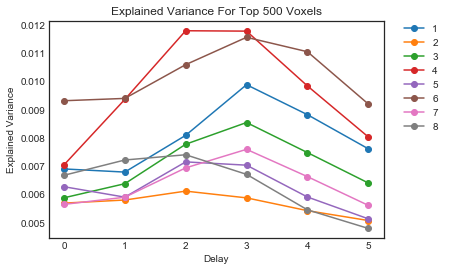

In [29]:
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import seaborn as sns


cmap = plt.cm.coolwarm
#plt.style.use('classic')
sns.set_style("white")
x = np.arange(6)
fig, (ax) = plt.subplots(1, 1, sharex=True)
for subject_id in [1,2,3,4,5,6,7,8]:
    lines = ax.plot(x,top_averaged_exp_var[subject_id],'o-',label=str(subject_id))
#    lines = ax2.plot(x,top_averaged_exp_var[subject_id],'o-',label=str(subject_id))


ax.set_title('Explained Variance For Top 500 Voxels')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Delay')
ax.set_ylabel('Explained Variance')

#ax.set_ylim(0.01, 0.012)  # outliers only
#ax2.set_ylim(0.0045, .01)  # most of the data    





fig.savefig("EV_Top500.png",bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=700)

In [ ]:
from matplotlib import rcParams, cycler
#import matplotlib.pyplot as plt
import seaborn as sns


cmap = plt.cm.coolwarm
#plt.style.use('classic')
sns.set_style("white")

x = np.arange(6)
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
for subject_id in [1,2,3,4,5,6,7,8]:
    lines = ax1.plot(x,top_averaged_exp_var[subject_id],'o-',label=str(subject_id))
    lines = ax2.plot(x,top_averaged_exp_var[subject_id],'o-',label=str(subject_id))


ax1.set_title('Explained Variance For Top 1200 Voxels')
lgd = ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2.set_xlabel('Delay')
ax1.set_ylabel('Explained Variance')

ax1.set_ylim(0.018, 0.025)  # outliers only
ax2.set_ylim(0.0035, .009)  # most of the data



# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


fig.savefig("EV_Top1200.png",bbox_extra_artists=(lgd,), bbox_inches='tight')

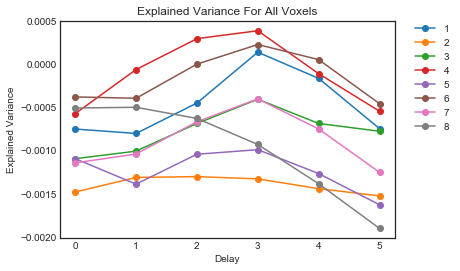

In [28]:
from matplotlib import rcParams, cycler
#import matplotlib.pyplot as plt
import seaborn as sns


cmap = plt.cm.coolwarm
#plt.style.use('classic')
sns.set_style("white")

x = np.arange(6)
fig, (ax) = plt.subplots(1, 1, sharex=True)
for subject_id in [1,2,3,4,5,6,7,8]:
    lines = ax.plot(x,averaged_exp_var[subject_id],'o-',label=str(subject_id))



ax.set_title('Explained Variance For All Voxels')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Delay')
ax.set_ylabel('Explained Variance')






fig.savefig("EV_All.png",bbox_extra_artists=(lgd,), bbox_inches='tight',dpi=700)

In [6]:

sub_id_index = 0
#nTRs
number_of_scans_index = 1
#nvoxels
number_of_voxels = 2
x_dim_index = 3
y_dim_index = 4
z_dim_index = 5
#colToCoord
colToCoord_index = 6
#coordToCol
coordToCol_index = 7
ROInumToName_index = 8
ROInumsToName_3d_index = 9
ROINames_index = 10
voxel_size_index = 11
#the map to the MNI space
matrix_index = 12
number_of_voxels = {}
area_names_list = {}
voxel_area_dic = {}
for subject_id in np.arange(1,9):
    voxel_area_dic[subject_id] = {}
    number_of_voxels[subject_id] = len(subject_file[subject_id]['meta'][0][0][ROInumToName_index][0])
    area_names_list[subject_id] = np.asarray(subject_file[subject_id]['meta'][0][0][ROINames_index][0])

    voxel_area_dic[subject_id] = {}
    j = 0;
    for i in np.arange(number_of_voxels[subject_id]):
        if i in intersection_voxels:
            if subject_file[subject_id]['meta'][0][0][ROInumToName_index][0][i] not in voxel_area_dic[subject_id].keys():
                voxel_area_dic[subject_id][subject_file[subject_id]['meta'][0][0][ROInumToName_index][0][i]]=[]

            voxel_area_dic[subject_id][subject_file[subject_id]['meta'][0][0][ROInumToName_index][0][i]].append(j)
            j += 1

NameError: name 'intersection_voxels' is not defined

In [153]:
subject_id = 1
len(averared_exp_vars[subject_id][0])

37683

In [154]:
area_wise_exp_var = {}
values={}
areas={}

for subject_id in np.arange(1,9):

    area_wise_exp_var[subject_id] = {0:{},1:{},2:{},3:{},4:{},5:{}}
    values[subject_id]={}
    areas[subject_id={}
    for d in [0,1,2,3,4,5]:
        for key in voxel_area_dic[subject_id].keys():
                #print("area name:", subject_file['meta'][0][0][ROINames_index][0][key][0])
                #print("number of voxels:",len(voxel_area_dic[key]))
                #mse_vector = np.sum(((predicted[model][:,voxel_area_dic[key]] - target[model][:,voxel_area_dic[key]] ) ** 2),axis=1)
                #mse_vector = cosine_dists.diagonal()
                #dist_sum += np.sum(mse_vector) 
            area_wise_exp_var[subject_id][d][subject_file[subject_id]['meta'][0][0][ROINames_index][0][key][0]] = \
            np.mean(np.asarray(averared_exp_vars[subject_id][d])[voxel_area_dic[subject_id][key]])

        values[subject_id][d] = []
        areas[subject_id][d] = []
        for area in area_wise_exp_var[d].keys():
            #print("%s,%f" %(area,area_wise_mse[model][area]))
            values[subject_id][d].append(area_wise_exp_var[d][area])
            areas[subject_id][d].append(area)
        with open("sub"+str(subject_id+"_d"+str(d)+".txt","w") as f:
            for area in area_wise_exp_var[subject_id][d].keys():
                f.write(area+","+str(area_wise_exp_var[subject_id][d][area])+"\n")

        

[52 25 28 66 30 65 42 35 64 23 68 67 84 62 26 85 59 51  4 54 19 80 55  1
  8 71 38 40 17 39  5 12 36 56 27 33 82 31 77 14 47 10 44 49 72 22 34 45
 43 74 15 75 89 50 21  6 73 58  2  9 32 86  0 69 16 88 29 37 57 70 53 83
 13  3 41 18 48 76 78 87 63 61 60 46  7 24 79 81 20 11]
number of areas:  90


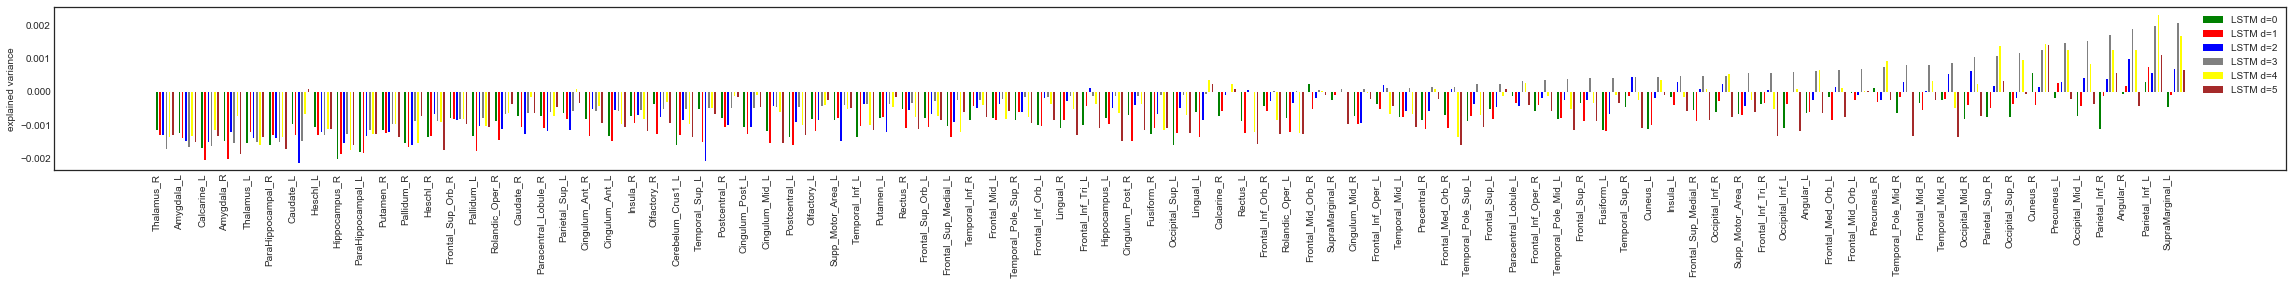

In [155]:
import matplotlib.pyplot as plt


sorted_ind = np.argsort(values[3])
print(sorted_ind)
N = len(area_wise_exp_var[0].keys())
print("number of areas: ",N)

ind = np.arange(0,N*7,7)  # the x locations for the groups
width = 0.5       # the width of the bars

fig, ax = plt.subplots(figsize=(40,3))
rects1 = ax.bar(ind,np.asarray(values[0])[sorted_ind], width, color='green',align='center')
rects2 = ax.bar(ind+1,np.asarray(values[1])[sorted_ind], width, color='red',align='center')
rects3 = ax.bar(ind+2,np.asarray(values[2])[sorted_ind], width, color='blue',align='center')
rects4 = ax.bar(ind+3,np.asarray(values[3])[sorted_ind], width, color='grey',align='center')
rects5 = ax.bar(ind+4,np.asarray(values[4])[sorted_ind], width, color='yellow',align='center')
rects6 = ax.bar(ind+5,np.asarray(values[5])[sorted_ind], width, color='brown',align='center')

                    
# add some text for labels, title and axes ticks
ax.set_ylabel('explained variance')
ax.set_xticks(ind)
ax.set_xticklabels(np.asarray(areas[3])[sorted_ind],rotation='vertical')

ax.legend((rects1,rects2,rects3,rects4,rects5,rects6),(["LSTM d=0","LSTM d=1","LSTM d=2","LSTM d=3","LSTM d=4","LSTM d=5"]))
plt.show()

In [169]:
sorted_ind_3 = np.argsort(values[3])
sorted_ind_4 = np.argsort(values[4])
print(np.asarray(areas[3])[sorted_ind_3][-10:])
print(np.asarray(areas[4])[sorted_ind_4][-10:])

['Occipital_Mid_R' 'Parietal_Sup_R' 'Occipital_Sup_R' 'Cuneus_R'
 'Precuneus_L' 'Occipital_Mid_L' 'Parietal_Inf_R' 'Angular_R'
 'Parietal_Inf_L' 'SupraMarginal_L']
['Occipital_Mid_L' 'Precuneus_R' 'Occipital_Sup_R' 'Angular_R'
 'Precuneus_L' 'Parietal_Inf_R' 'Parietal_Sup_R' 'Cuneus_R'
 'SupraMarginal_L' 'Parietal_Inf_L']


In [156]:
subject_file[subject_id]['meta'][0][0][colToCoord_index][0]

array([ 3, 23, 22], dtype=uint8)

In [157]:
fMRI_image = np.zeros((subject_file[subject_id]['meta'][0][0][x_dim_index][0][0]+1,
                subject_file[subject_id]['meta'][0][0][y_dim_index][0][0]+1,
                subject_file[subject_id]['meta'][0][0][z_dim_index][0][0]+1)) - 1

In [160]:
d=3
for i in intersection_voxels:
    fMRI_image[subject_file[subject_id]['meta'][0][0][colToCoord_index][i][0],subject_file[subject_id]['meta'][0][0][colToCoord_index][i][1],
              subject_file[subject_id]['meta'][0][0][colToCoord_index][i][2]] = averared_exp_vars[subject_id][d][np.where(intersection_voxels == i)[0]]
    
    
    

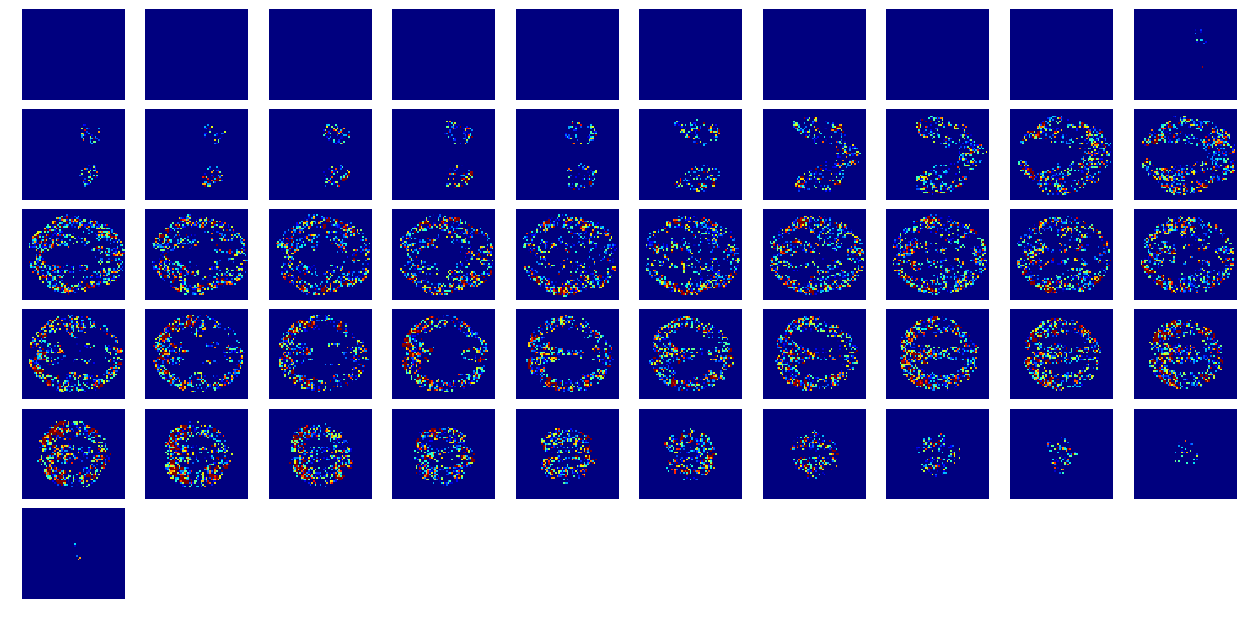

In [161]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.1)
for z in np.arange(subject_file[subject_id]['meta'][0][0][z_dim_index][0][0]+1):
    plt.subplot(6,10,z+1)
    plt.imshow(fMRI_image[:,:,z], cmap=plt.cm.jet,vmin=0,vmax=0.006)
    plt.axis("off")



In [162]:
fig.savefig("sub1_d3_fmri.png", bbox_inches='tight')